# 서울시 공공자전거 이용정보(2019 시간대별)
- 데이터 링크 : http://data.seoul.go.kr/dataList/OA-15245/F/1/datasetView.do


In [ ]:
# 한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [27]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/일일 데이터 분석

# # 압축해제
# import zipfile
# zipfile.ZipFile('./서울특별시 공공자전거 이용정보(시간대별)_2019년.zip').extractall('./공공자전거')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/일일 데이터 분석


In [2]:
# 필요 라이브러리
import numpy as np
import pandas as pd
import glob
import gc

import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# warnings 무시
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 지정
plt.rc('font', family='NanumBarunGothic')

# 소수점 두번째 자리까지 출력
pd.options.display.float_format = '{:.2f}'.format


# 색 팔레트
raw_light_palette = [
    (0, 122, 255), # Blue
    (255, 149, 0), # Orange
    (52, 199, 89), # Green
    (255, 59, 48), # Red
    (175, 82, 222),# Purple
    (255, 45, 85), # Pink
    (88, 86, 214), # Indigo
    (90, 200, 250),# Teal
    (255, 204, 0)  # Yellow
]

light_palette = np.array(raw_light_palette)/255

wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

In [3]:
# 데이터 병합
csv_list = glob.glob('./공공자전거/*.csv')

def merge_csv(csv_list):
  df = pd.DataFrame()
  for i in range(len(csv_list)):
    data_path = csv_list[i]
    try:
      data = pd.read_csv(data_path,encoding='cp949', low_memory = False)
      df = pd.concat([df,data],ignore_index=True)
    except UnicodeDecodeError:
      try:
        data = pd.read_csv(data_path, low_memory = False)
        df = pd.concat([df,data],ignore_index=True)
      except UnicodeDecodeError:
        data = pd.read_csv(data_path,encoding='utf-8', low_memory = False)
        df = pd.concat([df,data],ignore_index=True)  
  return df

In [4]:
bike_data = merge_csv(csv_list)

In [ ]:
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14291359 entries, 0 to 14291358
Data columns (total 12 columns):
 #   Column  Dtype  
---  ------  -----  
 0   대여일자    object 
 1   대여시간    int64  
 2   대여소번호   int64  
 3   대여소명    object 
 4   대여구분코드  object 
 5   성별      object 
 6   연령대코드   object 
 7   이용건수    int64  
 8   운동량     object 
 9   탄소량     object 
 10  이동거리    float64
 11  사용시간    int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 1.3+ GB


In [ ]:
bike_data.isnull().sum()

대여일자            0
대여시간            0
대여소번호           0
대여소명            0
대여구분코드          0
성별        7174668
연령대코드           0
이용건수            0
운동량             0
탄소량             0
이동거리            0
사용시간            0
dtype: int64

In [ ]:
bike_data.head()

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2019-06-01,0,740,740. 으뜸공원,정기권,NaN,~10대,1,42.91,0.40,1720.00,10
1,2019-06-01,0,951,951. 연신내역 6번출구옆,정기권,NaN,~10대,2,246.80,2.05,8830.00,55
2,2019-06-01,0,512,512. 뚝섬역 1번 출구 옆,정기권,NaN,~10대,1,60.98,0.36,1540.00,8
3,2019-06-01,0,1531,1531. 미아사거리 1번 출구,정기권,NaN,~10대,1,130.09,1.02,4380.00,24
4,2019-06-01,0,1656,1656. 중앙하이츠 아파트 입구,정기권,NaN,~10대,1,126.90,1.14,4930.00,23


In [31]:
# 요일 리스트
day_list = ['월','화','수','목','금','토','일']

def preprocessing(dataframe):
    df = dataframe.copy()

    # 성별 결측치 NA 로 대체
    df['성별'] = df['성별'].fillna('NA')

    # 성별 소문자 대문자로 통합
    df['성별'] = df['성별'].map(lambda x: 'F' if x == 'f' else 'M' if x == 'm' else x)

    # 대여구분코드 일일권(비회원)을 일일권으로 통합
    df['대여구분코드'] = df['대여구분코드'].map(lambda x: '일일권' if x == '일일권(비회원)' else x)

    # 월, 요일 컬럼 생성
    df['월'] = df["대여일자"].map(lambda x : int(str(x)[5:7]))
    df['요일'] = df['대여일자'].map(lambda x: day_list[datetime.datetime.strptime(x,'%Y-%m-%d').weekday()])

    # 시속 컬럼 생성
    df['평균속력'] = round((df["이동거리"]/1000) / (df["사용시간"]/60),2).replace(np.inf,0)

    # 운동량, 탄소량처리
    df['운동량'] = df['운동량'].map(lambda x: 0 if x == '\\N' else np.float(x))
    df['탄소절감량'] = df['탄소량'].map(lambda x: 0 if x == '\\N' else np.float(x))
    df = df.drop('탄소량',axis=1)  

    df = df.fillna(0)
    
    return df

In [32]:
bike_2019 = preprocessing(bike_data)

In [33]:
bike_2019.head()

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,이동거리,사용시간,월,요일,평균속력,탄소절감량
0,2019-06-01,0,740,740. 으뜸공원,정기권,NA,~10대,1,42.91,1720.00,10,6,토,10.32,0.40
1,2019-06-01,0,951,951. 연신내역 6번출구옆,정기권,NA,~10대,2,246.80,8830.00,55,6,토,9.63,2.05
2,2019-06-01,0,512,512. 뚝섬역 1번 출구 옆,정기권,NA,~10대,1,60.98,1540.00,8,6,토,11.55,0.36
3,2019-06-01,0,1531,1531. 미아사거리 1번 출구,정기권,NA,~10대,1,130.09,4380.00,24,6,토,10.95,1.02
4,2019-06-01,0,1656,1656. 중앙하이츠 아파트 입구,정기권,NA,~10대,1,126.90,4930.00,23,6,토,12.86,1.14


# 가설
1. 날씨가 좋은 봄과 가을에 이용객이 많을 것이다.
 * 월, 요일, 시간대별 공공자전거 이용현황은?<br><br>

2. 평일 저녁, 주말 오후 시간대의 이용객이 많을 것이다.
 * 이용객이 가장 많은 시간대와 가장 적은 시간대는?<br><br>

3. 한강 주변 이용객이 많을 것이다.
 * 이용객이 가장 많은 대여소는?<br><br>

4. 이용객은 평균 30분~1시간정도 자전거를 탈 것이다.
 * 이용객의 평균 대여 시간, 이동거리, 속력, 운동량, 탄소절감량은?<br><br>

5. 사용 시간과 이동거리, 평균속력, 운동량, 탄소절감량은 비례할 것이다.
 * 사용시간, 이동거리, 평균속력, 운동량, 탄소절감량간 상관관계는?<br><br>

6. 여성보다 남성의 사용시간, 이동거리, 평균속력, 운동량, 탄소절감량이 높을 것이다.
 * 성별에 따른 사용시간, 이동거리, 속력, 운동량, 탄소절감량 비교<br><br>

1. 연령대별 사용시간, 이동거리, 평균속력, 운동량, 탄소절감량에 차이가 있을 것이다.
 * 연령대별 사용시간, 이동거리, 평균속력, 운동량, 탄소절감량 비교<br><br>


In [52]:
# 범주형
def obj_plot(df,column_name,plot_type):
    data = df.copy()

    # 해당 컬럼의 class 파악
    if len(data[column_name].unique()) > 20:
        print(len(data[column_name].unique()))
    else:
        print(data[column_name].value_counts())


    plt.figure(figsize=(20,10))
    plt.subplot(2,3,1)
    plt.subplots_adjust(hspace=0.5)
    plot_df = data.groupby(column_name).sum()

    # 이용건수
    if column_name == '요일':
      sns.barplot(x=plot_df.index,y=plot_df['이용건수'],order = ['월','화','수','목','금','토','일'])
    elif column_name == '대여소명':
      plt.subplots_adjust(hspace=1)
      sns.barplot(x=plot_df.sort_values('이용건수')['이용건수'][::-1].index[:10] , y=plot_df.sort_values('이용건수')['이용건수'][::-1][:10])
      plt.xticks(rotation=90)
    elif plot_type == 'pie':
      plt.pie(plot_df['이용건수'],
              labels=plot_df.index,
              autopct='%.1f%%',
              startangle=260,
              shadow=True,
              wedgeprops=wedgeprops,
              colors=light_palette,
              textprops = {'fontsize':13})
    elif plot_type == 'bar':
      sns.barplot(x=plot_df.index,y=plot_df['이용건수'])

    plt.xlabel('')
    plt.ylabel('')
    plt.title(f'{column_name}별 이용건수',size=15)
    
    col_list = ['사용시간','이동거리','운동량','탄소절감량','평균속력']
    plot_df = data.groupby(column_name).mean()
    for i in range(len(col_list)):
      plt.subplot(2,3,2+i)
      if column_name == '요일':
        sns.barplot(x = plot_df.index, y=plot_df[col_list[i]],order = ['월','화','수','목','금','토','일'])
      elif column_name == '대여소명':
        plt.subplots_adjust(hspace=1)
        sns.barplot(x=plot_df.sort_values(col_list[i])[col_list[i]][::-1].index[:10] , y=plot_df.sort_values(col_list[i])[col_list[i]][::-1][:10])
        plt.xticks(rotation=90)
      else:
        sns.barplot(x = plot_df.index, y=plot_df[col_list[i]])

      plt.xlabel('')
      plt.ylabel('')
      plt.title(f'{column_name}별 {col_list[i]}',size=15)

    plt.show()
# 수치형
def num_plot(df,column_name):
  print(df[column_name].describe())

  # 그래프 사이즈 조절
  fig, ax = plt.subplots(1,2,figsize=(12,7))

  # 히스토그램
  sns.distplot(x = df[column_name],ax=ax[0]).set(xlabel='',ylabel='')

  # 박스플롯
  sns.boxplot(x = df[column_name],ax=ax[1]).set(xlabel='')

  # 그래프 간격조절
  # plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)
  
  # 그래프 제목
  plt.suptitle(column_name,size=20)
  
  plt.show()

# 이상값 처리
def outlier_iqr(df, column):
    data = df.copy()
    
    # 4분위수 기준 지정     
    q25, q75 = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)          
    
    # IQR 계산     
    iqr = q75 - q25    
    
    # outlier cutoff 계산   
    cut_off = iqr * 1.5          
    
    # lower와 upper bound 계산
    lower, upper = q25 - cut_off, q75 + cut_off     
    
    print('IQR은',iqr, '이다.')     
    print('lower bound 값은', lower, '이다.')     
    print('upper bound 값은', upper, '이다.')    
    
    
    del_outlier = data[(data[column] <= upper) & (data[column] > lower)]

    # 1사분위와 4사분위에 속해있는 데이터 각각 저장   

    outlier = data[(data[column] > upper) | (data[column] <= lower)]
    
    # 이상치 총 개수 구하기
    print('총 이상치 개수는', len(outlier), '이다.')

    return del_outlier

10    1817795
6     1736613
5     1693692
7     1645259
9     1544480
8     1532322
11    1244181
4     1197464
12     776956
3      532335
1      292732
2      277530
Name: 월, dtype: int64


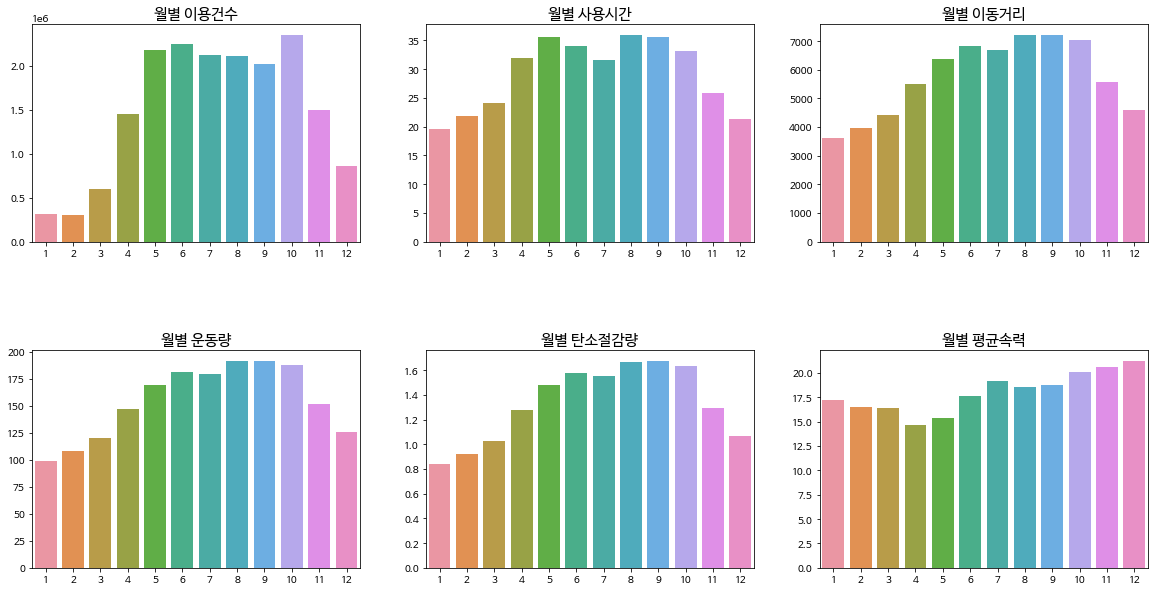

In [45]:
# 월별
obj_plot(bike_2019,"월",'bar')

- 공공자전거는 10월의 이용객이 가장 많았으며, 겨울에는 많이 이용하지 않는 것으로 보인다.
- 또한, 이용건수, 사용시간, 이동거리, 운동량, 탄소절감량 모두 여름에는 높아지고 겨울에 낮아진다.
- 따라서, 자전거는 날씨의 영향을 많이 받아 날이 좋은 봄, 여름, 가을에는 많이 이용하지만, 추운 겨울에는 자주 이용하지 않는다.

화    2218797
금    2131254
월    2106778
목    2042170
수    2012936
토    2000886
일    1778538
Name: 요일, dtype: int64


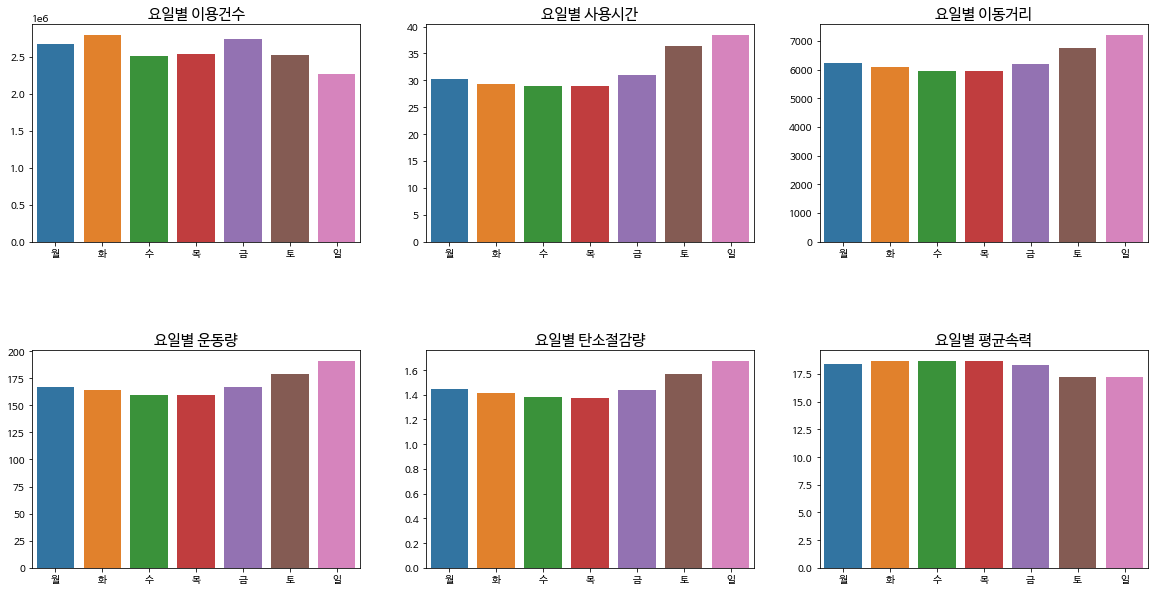

In [46]:
# 요일별
obj_plot(bike_2019,"요일",'bar')

- 요일별 이용객은 전체적으로 큰 차이가 없었지만, 일요일이 다른 요일에 비해 조금 적게 나타났다.

- 하지만, 사용시간에서 일요일이 가장 길었고, 토요일과 금요일 또한 평일보다 긴 것으로 보아 휴일의 이용객들이 보다 자전거를 오래 이용하는 것을 알 수 있다.

- 또한, 평균속력은 금토일이 조금 떨어지는 것으로 나타났는데, 휴일에 자전거를 이용하는 사람들은 오래타지만 천천히 여유롭게 즐기는 것으로 보인다.

24


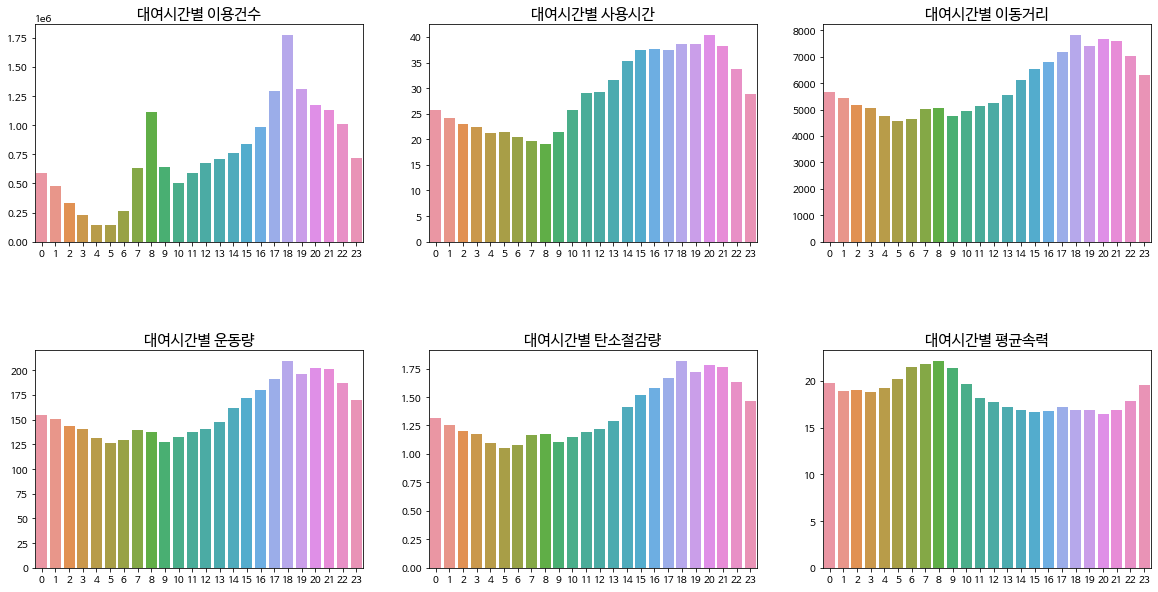

In [47]:
# 대여시간별
obj_plot(bike_2019,"대여시간",'bar')

- 대여시간별 이용객은 오전 8시와 오후 5 ~ 7시의 이용객이 많게 나타났다.
 - 출퇴근시간에 자전거를 이용하는 사람들의 영향이 있을것으로 생각된다<br><br>

- 대여시간별 사용시간은 오후 3시부터 오후 10시까지 높게 나타났다.
  - 날씨가 따뜻하고 선선한 시간대의 사용시간이 높다.<br><br>

- 또한, 저녁시간대의 이동거리, 운동량, 평균속력으로 보아 긴 거리를 천천히 오래 타는 유산소 운동을 하는 이용객들이 많아 보인다.

정기권    11671284
일일권     2513121
단체권      106954
Name: 대여구분코드, dtype: int64


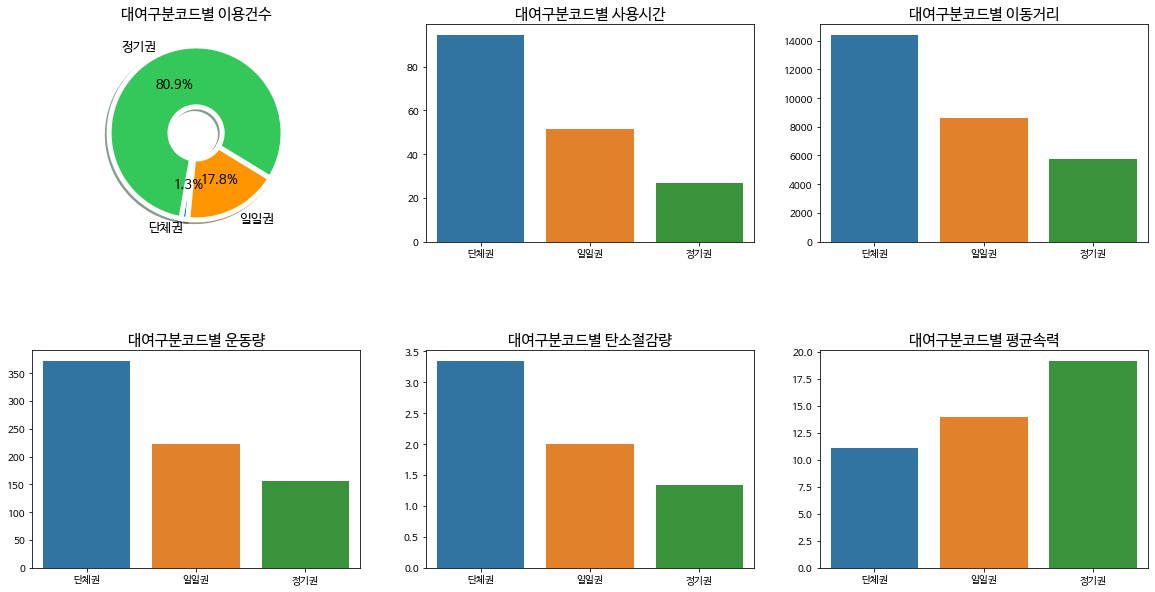

In [48]:
obj_plot(bike_2019,"대여구분코드",'pie')

- 80%이상 대부분의 이용객들은 정기권을 사용하고 있으며, 몇몇은 일일권과 단체권으로 자전거를 이용하고 있다.<br><br>

- 정기권을 이용하는 사람이 대부분이었지만, 정기권의 평균 사용시간은 가장 짧았다.
  - 출퇴근과 같이 정기적으로 가까운 거리를 이용하는 사람들이 많을 것이다 <br><br>

- 또한, 단체권을 이용하는 사람들은 매우 적었지만, 평균 사용시간은 가장 긴 것으로 나타났다.
 - 단체로 함께 이동하기 때문에 먼거리를 천천히 이동하는 것으로 보인다.

NA    7174668
M     4487771
F     2628920
Name: 성별, dtype: int64


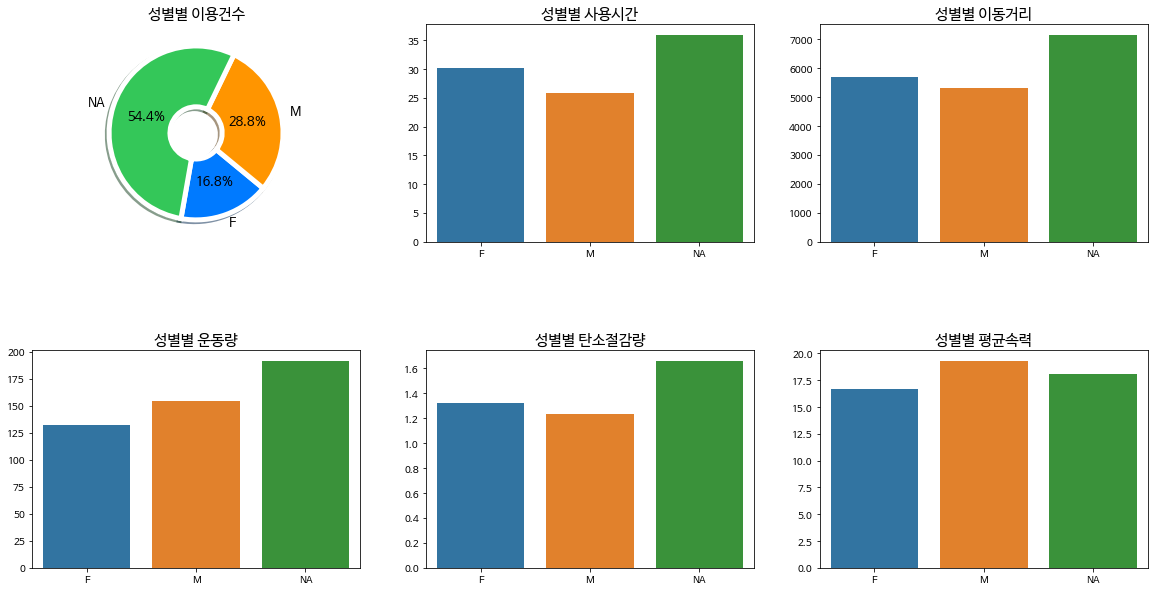

In [49]:
obj_plot(bike_2019,"성별",'pie')

- 성별은 자전거에서 자동으로 측정되는 데이터가 아니다보니 50% 이상의 결측치가 나타난 것으로 보인다.

- 여성보다 남성의 이용객이 많게 나타났지만, 평균 사용시간과 이동거리는 여성이 남성보다 높게 나타났다.

- 하지만, 평균 운동량에서 남성이 더 높았는데 이는 남성이 여성보다 평균속력이 높기 때문에 운동효과가 있었던 것으로 보인다.

20대     6432342
30대     3415676
40대     2158586
50대     1214461
~10대     700479
60대      302484
70대~      67331
Name: 연령대코드, dtype: int64


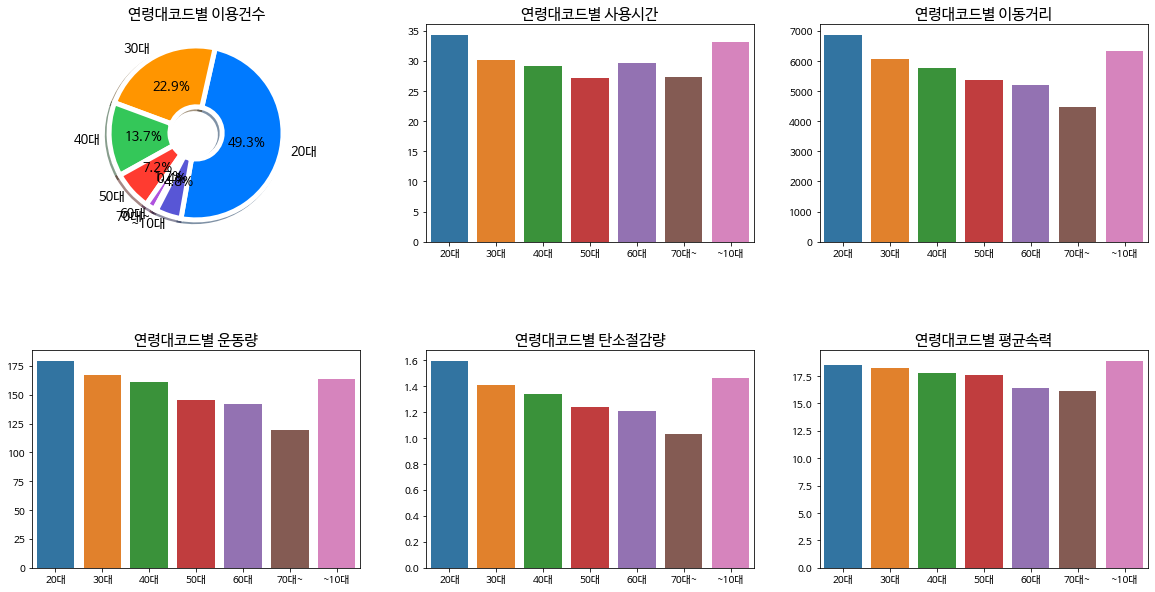

In [50]:
obj_plot(bike_2019,"연령대코드",'pie')

- 공공자전거 이용은 20대가 거의 절반을 차지하였으며, 연령대가 높아질수록 이용객이 줄어드는 것을 볼 수 있다.
- 이용건수 뿐만 아니라 나머지 변수들 또한 전체적으로 10,20대가 높았으며, 연령대가 높아질수록 줄어든다.

1573


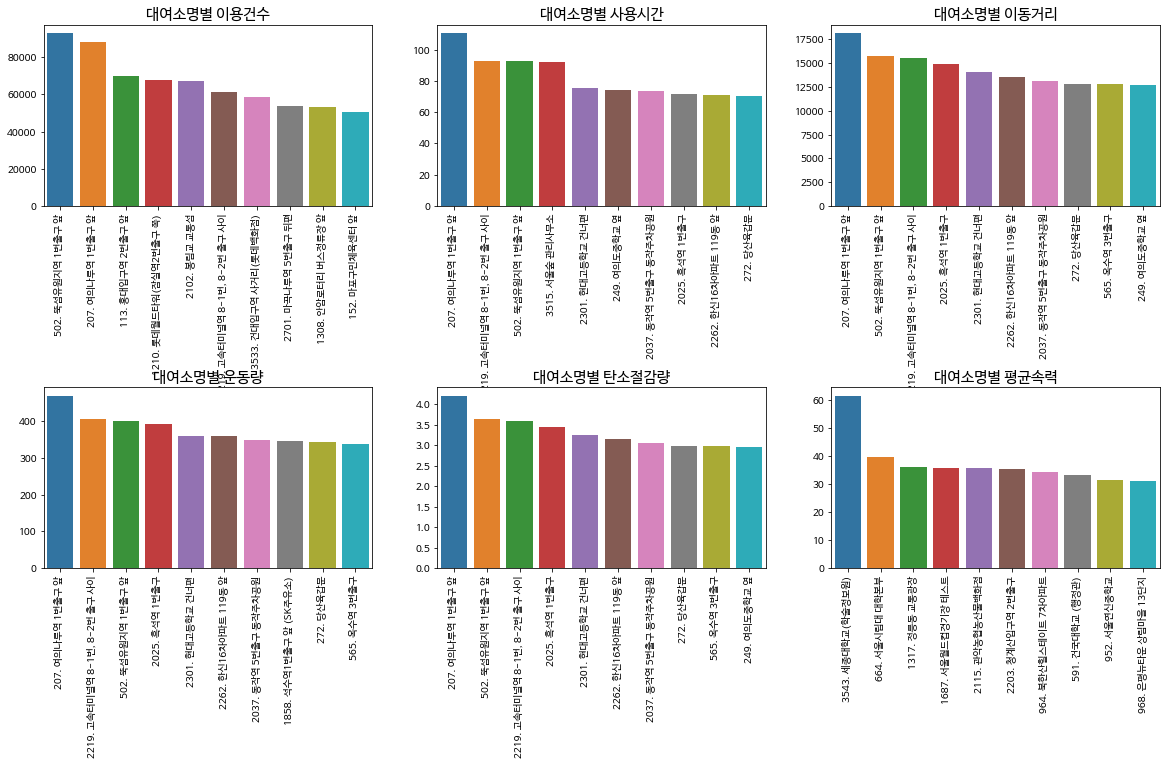

In [53]:
obj_plot(bike_2019,'대여소명','bar')

- 이용객이 많은 대여소들은 모두 한강, 호수공원, 서울숲과 같은 휴양장소 근처와 교통이 편리한 지하철 역 근처로 많이 나타났다.

count   14291359.00
mean          31.75
std           43.49
min            0.00
25%            8.00
50%           18.00
75%           40.00
max        22183.00
Name: 사용시간, dtype: float64


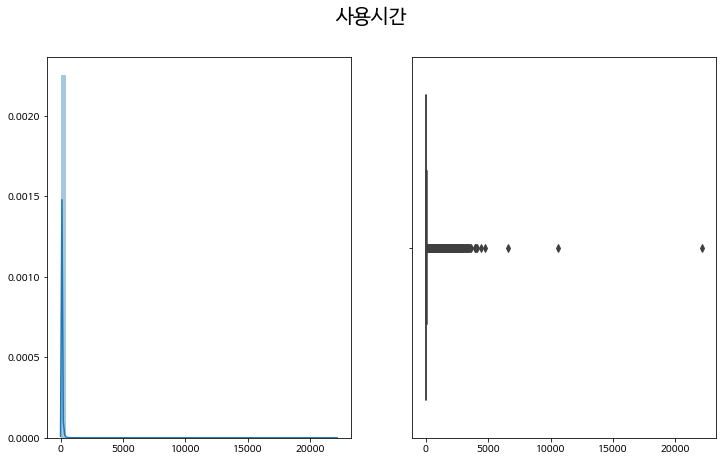

In [ ]:
# 이용객들의 사용시간 분포
num_plot(bike_2019,"사용시간")

- 전체 공공자전거 이용객들은 평균 약 32분을 이용하는 것으로 나타났으며, 최대 22183분의 이용객이 존재한다.
- 수천, 수만분을 사용하는 이용객은 일반적으로 있을수가 없으므로, 잘못된 데이터라 판단하여 하루(24시간)을 넘어가는 자전거는 제외하여 시각화

count   14290888.00
mean          31.69
std           41.45
min            0.00
25%            8.00
50%           18.00
75%           40.00
max         1440.00
Name: 사용시간, dtype: float64


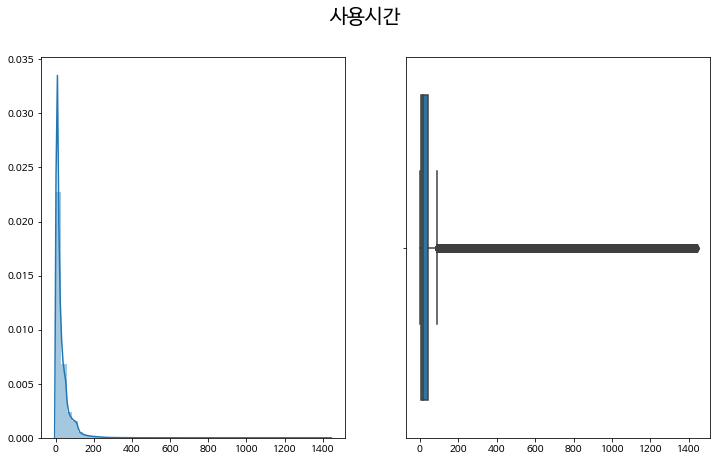

In [56]:
filter_1 = bike_2019[bike_2019['사용시간'] <= 1440]
num_plot(filter_1,"사용시간")

- 공공자전거 이용객들은 약 32분을 이용하는 것으로 나타났다.

IQR은 113.57000000000001 이다.
lower bound 값은 -137.185 이다.
upper bound 값은 317.095 이다.
총 이상치 개수는 1498107 이다.
count   12793252.00
mean          80.70
std           69.33
min            0.00
25%           30.59
50%           57.19
75%          109.91
max          317.09
Name: 운동량, dtype: float64


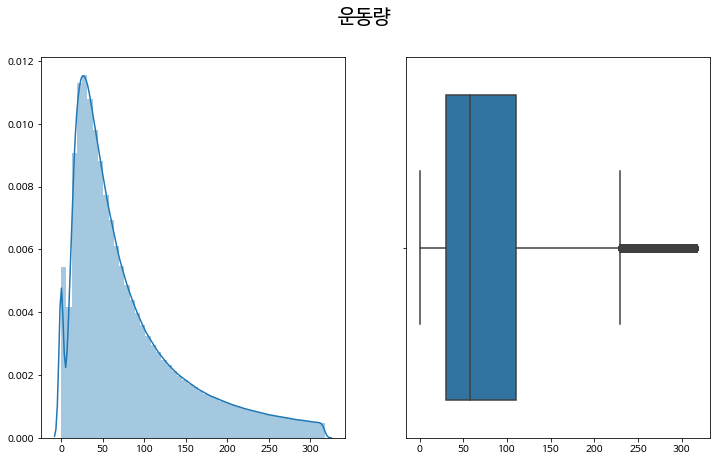

In [64]:
# IQR 방식으로 이상값 제거 후 시각화
filter_2 = outlier_iqr(bike_2019,'운동량')
num_plot(filter_2,"운동량")

- 평균 약 81의 운동량을 보인다.

IQR은 0.99 이다.
lower bound 값은 -1.1949999999999998 이다.
upper bound 값은 2.7649999999999997 이다.
총 이상치 개수는 1488645 이다.
count   12802714.00
mean           0.71
std            0.60
min            0.00
25%            0.27
50%            0.50
75%            0.96
max            2.76
Name: 탄소절감량, dtype: float64


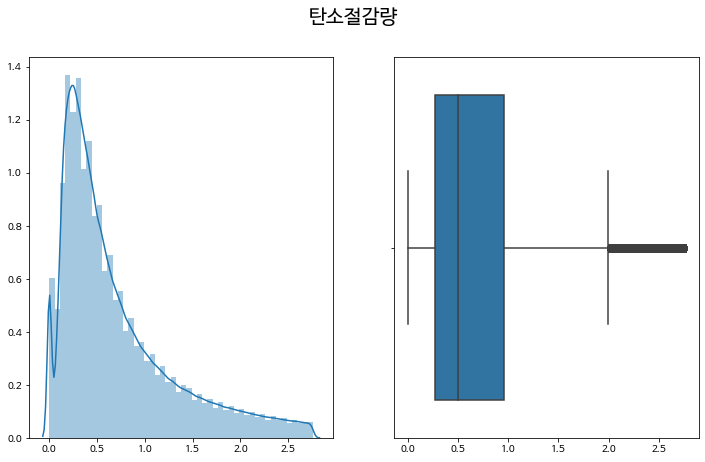

In [63]:
filter_3 = outlier_iqr(bike_2019,'탄소절감량')
num_plot(filter_3,'탄소절감량')

- 평균 약 0.71의 탄소절감량을 보인다

IQR은 4240.0 이다.
lower bound 값은 -5100.0 이다.
upper bound 값은 11860.0 이다.
총 이상치 개수는 1496811 이다.
count   12794548.00
mean        3038.15
std         2595.79
min            0.00
25%         1160.00
50%         2160.00
75%         4130.00
max        11860.00
Name: 이동거리, dtype: float64


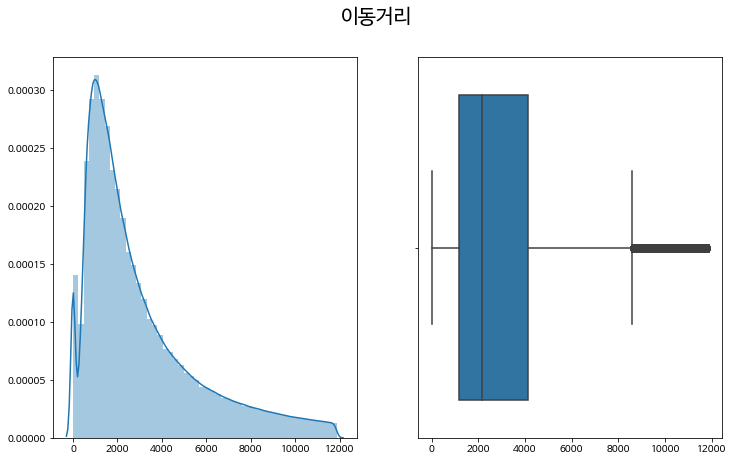

In [62]:
filter_4 = outlier_iqr(bike_2019,'이동거리')
num_plot(filter_4,'이동거리')

- 자전거 이용객들은 평균 약 3038m의 거리를 이동한다

IQR은 5.130000000000001 이다.
lower bound 값은 -0.5250000000000012 이다.
upper bound 값은 19.995 이다.
총 이상치 개수는 599500 이다.
count   13691859.00
mean           9.31
std            3.94
min            0.00
25%            7.02
50%            9.52
75%           11.90
max           19.99
Name: 평균시속, dtype: float64


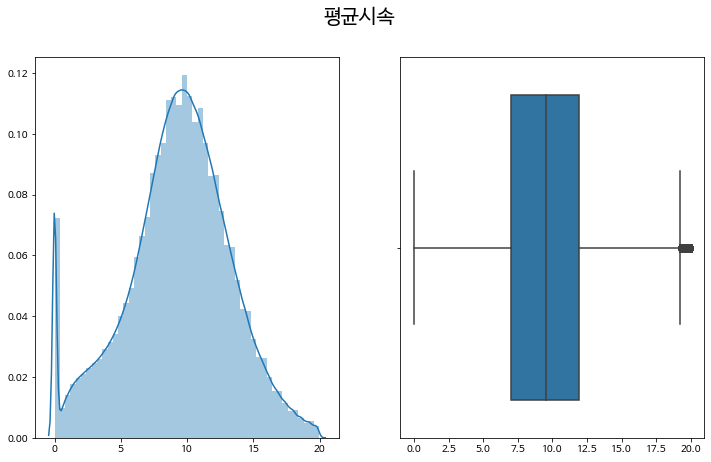

In [ ]:
filter_5 = outlier_iqr(bike_2019,'평균속력')
num_plot(filter_5,'평균속력')

- 자전거 이용객은 평균 약 9km/h의 속력으로 이용한다

IQR은 113.55 이다.
lower bound 값은 -137.15499999999997 이다.
upper bound 값은 317.04499999999996 이다.
총 이상치 개수는 1497921 이다.
IQR은 0.69 이다.
lower bound 값은 -0.7649999999999999 이다.
upper bound 값은 1.9949999999999999 이다.
총 이상치 개수는 725814 이다.
IQR은 2520.0 이다.
lower bound 값은 -2660.0 이다.
upper bound 값은 7420.0 이다.
총 이상치 개수는 395259 이다.
IQR은 4.94 이다.
lower bound 값은 -0.6100000000000003 이다.
upper bound 값은 19.15 이다.
총 이상치 개수는 147355 이다.


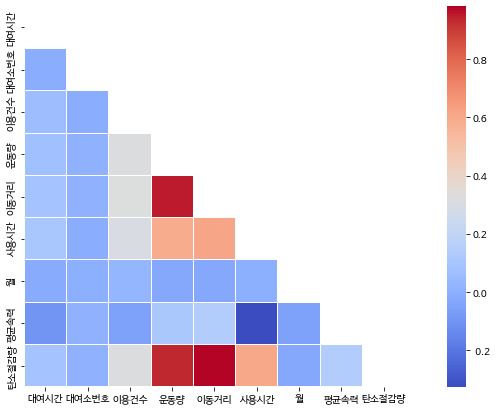

In [65]:
# 변수간 상관관계
filter_0 = bike_2019[bike_2019['사용시간'] <= 1440]
filter_1 = outlier_iqr(filter_0,'운동량')
filter_2 = outlier_iqr(filter_1,'탄소절감량')
filter_3 = outlier_iqr(filter_2,'이동거리')
filter_4 = outlier_iqr(filter_3,'평균속력')

plt.figure(figsize=(15,7))
mask = np.zeros_like(filter_1.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(filter_1.corr(), cmap='coolwarm',linewidth=0.05,square=True,mask=mask)

- 이동거리,탄소절감량,운동량은 강한 양의 상관관계를 보이는 것으로 서로 비례하는 것을 볼 수 있다.
- 사용시간과 이동거리,탄소절감량,운동량은 약한 양의 상관관계를 가진다.
- 평균시속과 사용시간은 약한 음의 상관관계를 보인다.

# 시각화 결과
1. 날씨가 좋은 봄과 가을에 이용객이 많을 것이다.
 * 월별 공공자전거 이용현황은?<br><br>
  a) 공공자전거 이용은 계절의 영향을 많이 받아 겨울에는 적고 봄,여름,가을에 걸쳐 점차 많아진다<br><br>
 

2. 평일 저녁, 주말 오후 시간대의 이용객이 많을 것이다.
 * 이용객이 가장 많은 시간대와 가장 적은 시간대는?<br><br>
  a) 금토일과 같이 휴일의 이용량이 많으며, 출근시간과 퇴근시간 그리고 저녁시간대의 이용량이 많은데, 출퇴근과 운동을 목적으로 이용하는 사람들이 많은 것으로 추측할 수 있다<br><br>

3. 한강 주변 이용객이 많을 것이다.
 * 이용객이 가장 많은 대여소는?<br><br>
  a) 뚝섬과 여의나루역 주변 대여소의 이용객이 가장 많았으며, 접근성이 좋고 자전거를 타기 좋은 환경이 갖추어져 있는 대여소가 이용량이 많았다.<br><br>


4. 이용객은 평균 30분~1시간정도 자전거를 탈 것이다.
 * 이용객의 평균 대여 시간, 이동거리, 속력, 운동량, 탄소절감량은?<br><br>
  a) 이용객들은 약 32분을 이용하며, 약 3km를 이동한다<br><br>

5. 사용 시간과 이동거리, 평균속력, 운동량, 탄소절감량은 비례할 것이다.
 * 사용시간, 이동거리, 평균속력, 운동량, 탄소절감량간 상관관계는?<br><br>
  a) 이동거리,탄소절감량,운동량은 강한 양의 상관관계를 보이는 것으로 서로 비례하는 것을 볼 수 있다.<br><br>
  b) 사용시간과 이동거리,탄소절감량,운동량은 약한 양의 상관관계를 가지며, 평균속력과 사용시간은 약한 음의 상관관계를 보인다.<br><br>

6. 여성보다 남성의 사용시간, 이동거리, 평균속력, 운동량, 탄소절감량이 높을 것이다.
 * 성별에 따른 사용시간, 이동거리, 속력, 운동량, 탄소절감량 비교<br><br>
  a) 여성이 사용시간 및 이동거리는 더 길었지만, 속력과 운동량에서는 남성이 더 높게 나타났다.<br><br>

7. 연령대별 사용시간, 이동거리, 평균속력, 운동량, 탄소절감량에 차이가 있을 것이다.
 * 연령대별 사용시간, 이동거리, 평균속력, 운동량, 탄소절감량 비교<br><br>
  a) 연령대가 젊을수록 전체적인 칼럼들이 모두 길거나 높았으며, 연령대가 올라갈수록 점차 낮아졌다.
